In [114]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df=pd.read_csv("Flight_delay.csv")

In [118]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


In [120]:
df.columns

Index(['DayOfWeek', 'Date', 'DepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'Airline', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin',
       'Org_Airport', 'Dest', 'Dest_Airport', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [122]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


In [124]:
df.isnull().sum()

DayOfWeek       0
Date            0
DepTime         0
Airline         0
Origin          0
Dest            0
CarrierDelay    0
dtype: int64

In [126]:
df['Date']=pd.to_datetime(df['Date'], dayfirst=True)

In [128]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [130]:
df=df.drop(columns=['Date'])
df['DepHour'] = df['DepTime'] // 100

In [132]:
categorical_var = df.select_dtypes(include=['object']).columns
categorical_var

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [134]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [136]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)

In [138]:

X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [141]:
train_set = pd.concat([X_train, y_train], axis= 1)

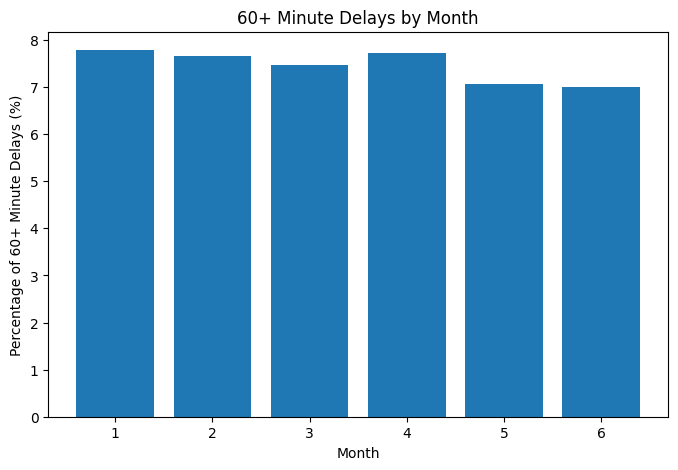

In [144]:
# Delay percentage by month
month_delay = train_set.groupby('month')['is_delayed_60+'].mean() * 100

plt.figure(figsize=(8,5))
plt.bar(month_delay.index, month_delay.values)
plt.xlabel("Month")
plt.ylabel("Percentage of 60+ Minute Delays (%)")
plt.title("60+ Minute Delays by Month")
plt.show()


In [146]:
categorical_var

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [148]:
for category in categorical_var:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [149]:
train_set

,DayOfWeek,DepTime,month,day,DepHour,is_delayed_60+,Airline,Origin,Dest
132504,5,2124,2,22,21,0,US Airways Inc.,PHX,LAS
483050,4,2218,6,19,22,0,American Airlines Inc.,DFW,OAK
318401,6,1500,4,26,15,1,American Airlines Inc.,ORD,MIA
259287,3,2112,3,12,21,1,American Airlines Inc.,JNU,SEA
77835,6,1730,1,26,17,0,American Airlines Inc.,SJU,ORD
...,...,...,...,...,...,...,...,...,...
439107,4,1707,6,19,17,0,United Air Lines Inc.,PIT,ORD
117952,3,1752,2,27,17,0,Skywest Airlines Inc.,ORD,LAN
435829,2,1826,6,24,18,0,United Air Lines Inc.,LAX,ORD
305711,1,1350,4,21,13,0,Atlantic Southeast Airlines,SAT,ATL


In [152]:
train_set['is_delayed_60+'].value_counts()

is_delayed_60+
0    313876
1     25309
Name: count, dtype: int64

In [154]:
train_set['is_delayed_60+'].mean()

0.07461709686454294

In [156]:
#Which airlines have the highest probability of long delays?
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

Airline
Atlantic Southeast Airlines     16.3
Hawaiian Airlines Inc.          14.2
Skywest Airlines Inc.           10.3
American Airlines Inc.           9.0
Delta Air Lines Inc.             8.4
US Airways Inc.                  7.6
United Air Lines Inc.            7.5
American Eagle Airlines Inc.     7.0
JetBlue Airways                  5.9
Frontier Airlines Inc.           4.7
Southwest Airlines Co.           3.3
Name: is_delayed_60+, dtype: float64

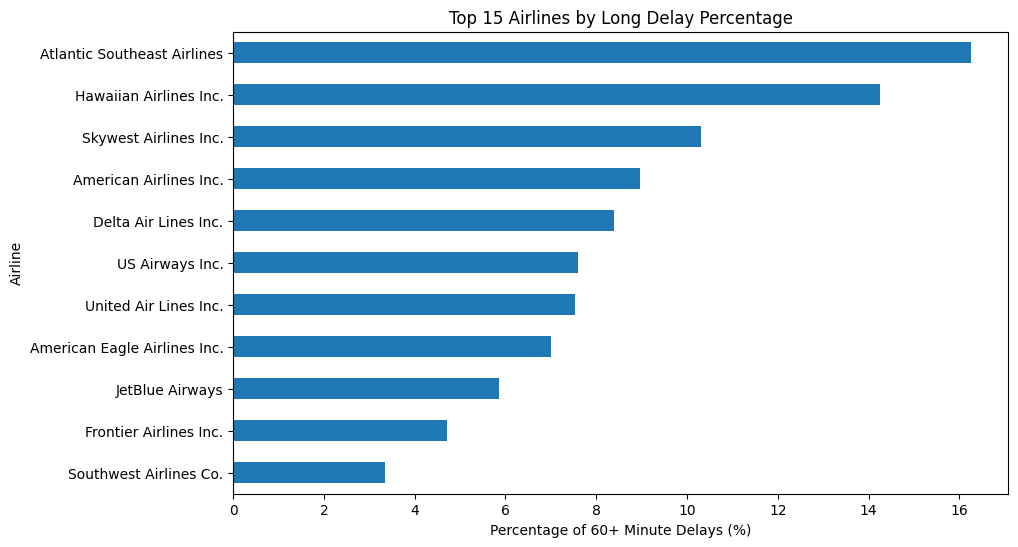

In [158]:
top_airlines = (
    train_set.groupby('Airline')['is_delayed_60+']
    .mean()
    .sort_values(ascending=False)
    .head(15) * 100
)

plt.figure(figsize=(10,6))
top_airlines.sort_values().plot(kind='barh')
plt.xlabel("Percentage of 60+ Minute Delays (%)")
plt.title("Top 15 Airlines by Long Delay Percentage")
plt.show()


In [160]:
#calculates Week day-wise delay percentage 
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

DayOfWeek
1    7.6
2    7.1
3    7.6
4    6.9
5    6.8
6    9.0
7    7.9
Name: is_delayed_60+, dtype: float64

In [162]:
#calculates Origin airport-wise delay percentag
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

Origin
LWB    40.0
ACY    40.0
MQT    33.8
MCN    27.8
SLE    26.7
SCE    25.0
PFN    23.6
PHF    23.1
MKG    22.6
TRI    22.5
MEI    22.2
HHH    21.8
OAJ    21.5
FAY    21.4
ROW    21.4
VLD    20.3
AVL    19.8
ABI    19.4
EWN    19.3
CMI    18.4
Name: is_delayed_60+, dtype: float64

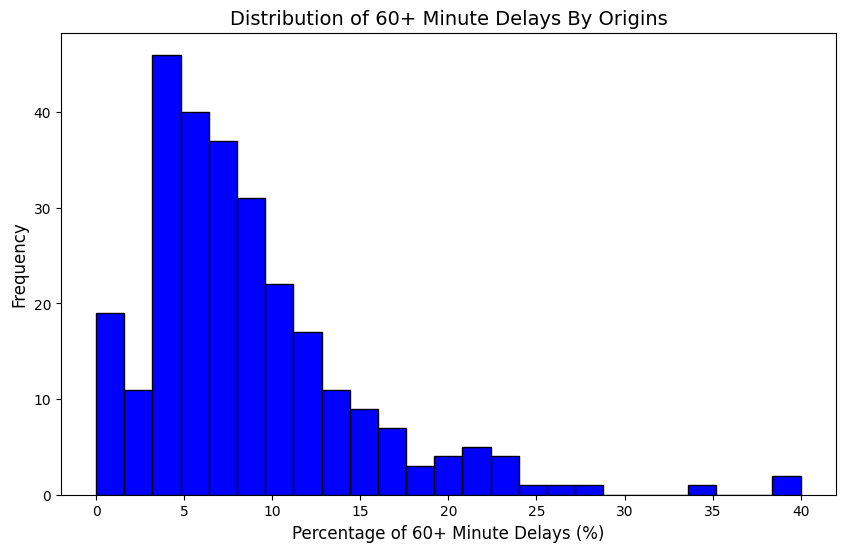

In [164]:
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

In [214]:
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

print("Scale Pos Weight:", scale_pos_weight)


# ==============================
# STEP 12: Baseline XGBoost Model
# ==============================
xgb_base = xgb.XGBClassifier(
    random_state=42,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)


Scale Pos Weight: 12.401754316646253


In [195]:
xgb_model 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [197]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [199]:
y_pred = xgb_model.predict(X_test)

Since only ~7% of flights are delayed, the dataset is highly imbalanced. Therefore, ROC-AUC is used as the primary evaluation metric instead of accuracy.

In [201]:
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

XGBoost Classifier (Baseline):
Accuracy: 0.6709


In [203]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[90582, 43801],
       [ 4045,  6938]], dtype=int64)

In [205]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]


In [207]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 0.7119


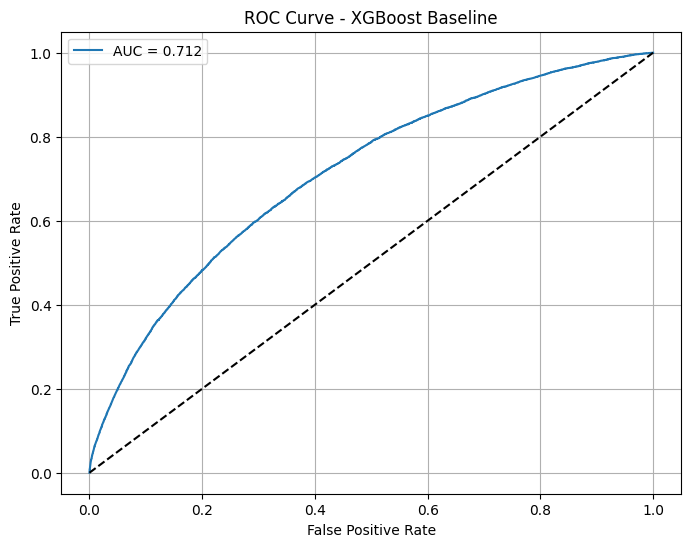

In [209]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Baseline")
plt.legend()
plt.grid()
plt.show()


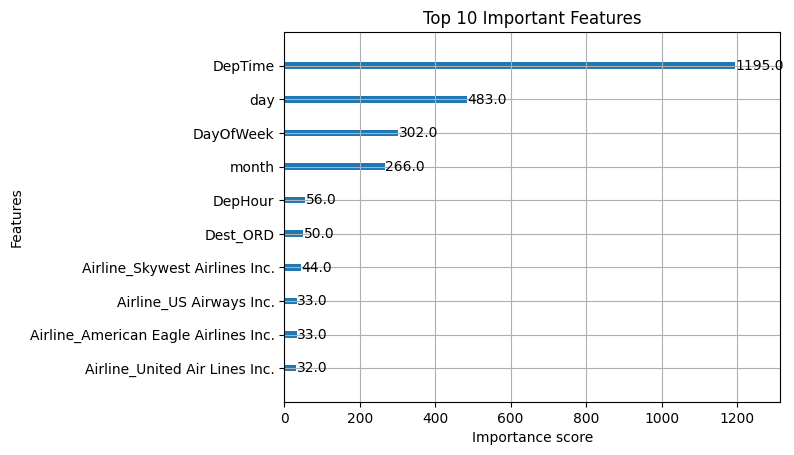

In [212]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()
